# Getting started with pyEyeBall #

In this example, we will use pyEyeBall to compute cone absorptions and membrane current for scene defined by a RGB image on a calibrated display. For simplicity, we default values for customizable parameters throughout this tutorial. For detailed explanation of the attributes and parameters, check their own tutorials and the online api documents.

## Import module and class
All the commonly used modules and classes can be imported directly from the top level. For example, to import Illuminant class, just call
<pre><code>from pyEyeBall import Illuminant</code></pre>
In this tutorial, we use Display, Scene, Optics and coneOuterSegmentMosaic class.

In [1]:
%matplotlib inline

from pyEyeBall import Display, Scene, Optics, ConeOuterSegmentMosaic
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread

## Load Calibrated Display ##
In pyEyeBall, we can directly load calibrated display file from .mat file from MATLAB [ISETBIO](http://isetbio.github.io/isetbio/ "isetbio") toolbox. To list all available calibrated displays, call static method of class as
<pre><code>Display.ls_display()</code></pre>
And you could get something like:

In [2]:
Display.ls_display()

['CRT-Dell.mat',
 'CRT-HP.mat',
 'crt.mat',
 'Dell-Chevron.mat',
 'LCD-Apple.mat',
 'LCD-Dell.mat',
 'LCD-Gechic.mat',
 'LCD-HP.mat',
 'lcdExample.mat',
 'OLED-Samsung.mat',
 'OLED-Sony.mat']

Now, we create a Sony OLED display and have a look at the properties of that display. To create a display with ISETBIO .mat file, call class-method init_with_isetbio_mat_file as:

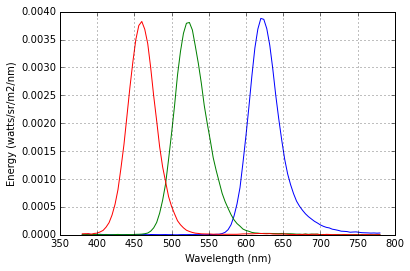

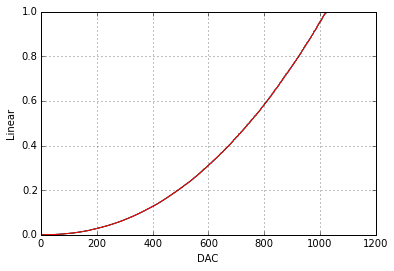

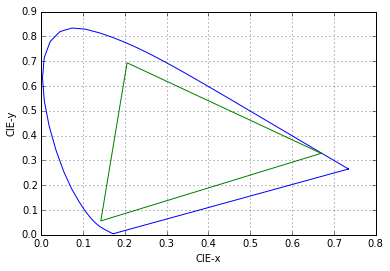

In [3]:
d = Display.init_with_isetbio_mat_file("OLED-Sony.mat")
d.plot('spd')  # plot power spectrum distribution
d.plot('gamma')  # gamma distortion of the display
d.plot('gamut')  # color gamut of the display

## Generate scene radiance map from an RGB image
First, let's load an RGB image. Here, we load it from web with url link. You could also use imread function from scipy.ndimage / scipy.misc, skimage or cv2 packages to load local image files.
In most cases, image will be loaded with data type numpy.uint8. That means values are between 0 and 255. In pyEyeBall, we always use images between 0 and 1 as float. Thus, remember to do the conversion here.

In [4]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get("http://scarlet.stanford.edu/validation/SCIEN/RGB/LStryer/rocksWater.jpg")
image = np.array(Image.open(BytesIO(response.content))).astype(float)/255.0

At this point, we have the display and image on hand and we are ready to generate the full spectra radiance map. To achieve this, call class method init_with_display_image as:

Scene Object: Scene from Display Image
  Wavelength: 380.0:4.0:780.0 nm
  [Row, Col]: (500, 800)
  [Width, Height]: [0.48, 0.3] m
  Horizontal field of view: 25 deg
  Sample size: 0.00059 meters/sample
  Mean luminance: 63 cd/m2


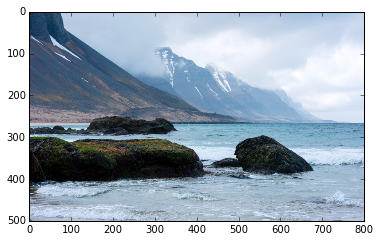

In [5]:
scene = Scene.init_with_display_image(d, image)  # create scene
print(scene)  # show description of the scene
scene.plot('srgb')

Now, let's modify a little the mean luminance and field of view of the scene

In [6]:
scene.mean_luminance = 100  # adjust mean luminance level to be 100 cd/m2
scene.fov = 1  # horizontal field view to be 1 degree

The radiance data are stored in .photons field in shape of (n_rows, n_cols, n_wavelength)

In [7]:
scene.photons.shape

(500, 800, 101)

## Human Optics and Irradiance Calculation ##
Standard Human optics can be created with Optics class in pyEyeBall simply as

In [8]:
oi = Optics()
print(oi)

Human Optics Instance: Human Optics
  Wavelength: 400.0:10.0:700.0 nm
  Horizontal field of view: 1 deg
  Pupil Diameter: 3 mm
  Focal Length: 17 mm



The ocular transmittance, optical transfer function and point spread function at different wavelength can be visualized as

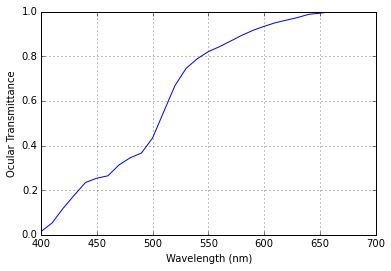

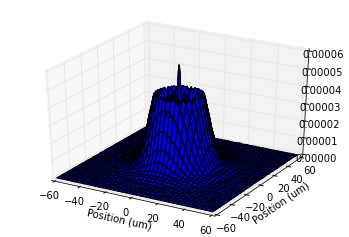

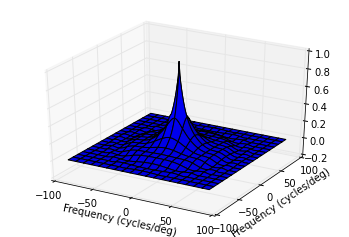

In [9]:
oi.plot('ocular transmittance')  # ocular transmittance, including macular pigment transmittance and lens transmittance
oi.plot('psf', 450)  # plot point spread function with wavelength sample at 450 nm
oi.plot('otf', 620)  # plot opitcal transfer function with wavelength sample at 620 nm

<strong> Note: </strong> that macular pigment transmittance and lens transmittance are all stored in Optics class in pyEyeBall, which is different from ISETBIO.

To compute the irradiance image, we can call compute method of Optics class, which requires the scene instance with radiance information.

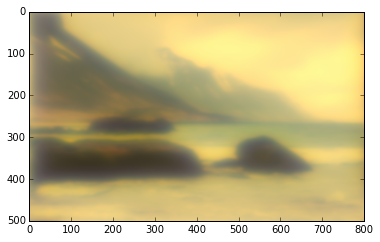

In [10]:
oi.compute(scene)
oi.plot('srgb')  # show optical irradiace image as srgb

## Cone Photopigment and Photon Absorptions ##
In this stage, we will compute cone photon absorptions in a randomly created mosaic. To tune parameters for cone photopigments, use ConePhotopigment class. Here, since we are using the default photopigments, we can simply call ConeOuterSegment() as below

Human Cone Mosaic: Human Cone Mosaic
  [Height, Width]: [0.142, 0.174] mm
  Field of view: 0.5765 deg
  Cone diameter: 2 um
  Integration time: 50 ms
  Spatial density (K,L,M,S):[ 0.   0.6  0.3  0.1]


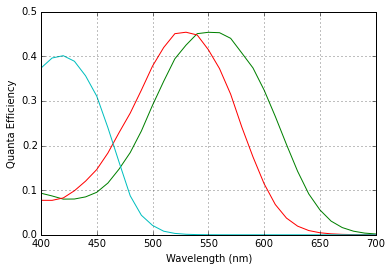

In [11]:
sensor = ConeOuterSegmentMosaic()
print(sensor)
sensor.plot('quanta efficiency')

We need to tell sensor how large it would be. By default, it's 72x88 cones, which is fairly small. We can directly set the size or set by the horizontal field of view. Here, we set the mosaic to have same field of view of the scene.

In [12]:
sensor.fov = scene.fov

To compute the cone size more accurately from the field of view, we need the image distance of the optics. We can pass this information as

In [13]:
sensor.set_fov(scene.fov, oi)

Compute photon absorptions of the cones can be completed with compute method. An optional input argument is add_noise, which indicates whether to not to add photon noise in the computation.

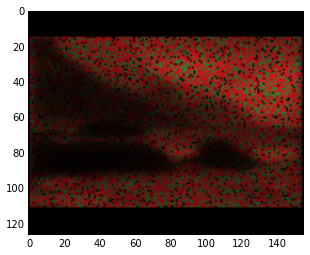

In [14]:
sensor.compute(oi, add_noise=True)
sensor.plot('rgb')  # show the absorption image

The photon absorptions data are stored in the .photons field in shape of (n_rows, n_cols, n_samples). Here, we haven't set up eye movement yet and thus, n_samples is equal to 1.

In [15]:
sensor.photons.shape

(126, 155, 1)

## Eye Movement and Cone Membrane Current ##
Fixational eye movement path can be generated with init_eye_movement method. To adjust parameters of the fixational eye movement, use FixationalEyeMovement class. Here, we generate 1000 samples from using the default parameters.

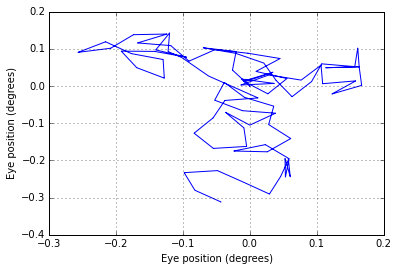

In [16]:
sensor.init_eye_movement(n_samples=1000)
sensor.plot('eye movement')

Now, compute cone absorptions at each position again

In [ ]:
sensor.compute(oi)
sensor.photons.shape

(126, 155, 1000)

To get the cone membrane current from adaptation, we can use properties current_noisefree and current. As their names suggest, the current_noisefree adds no cone noise while current includes that noise.

<strong>Note:</strong> both current and current_noisefree are computed properties. So, if you need to use if multiple times, store current to local variable to avoid computing them multiple times.

In [ ]:
sensor.current.shape